In [1]:
# Importing necessary libraries
import pandas as pd

# Loading the dataset
file_path = "Mall_Customers.csv"  # Adjust the file path if needed
df = pd.read_csv(file_path)

# Displaying the first few rows
print(df.head())

# Displaying basic information about the dataset
print(df.info())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Defining columns
cat_cols = ['Genre']
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Creating a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),            # Standardize numerical columns
        ('cat', OneHotEncoder(drop='first'), cat_cols)  # One-hot encode categorical column
    ]
)

# Applying the preprocessing pipeline
df_processed = preprocessor.fit_transform(df)

# Converting processed data to DataFrame
processed_col_names = num_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
df_processed = pd.DataFrame(df_processed, columns=processed_col_names)

# Displaying the first few rows of the processed dataset
print(df_processed.head())

        Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male
0 -1.424569           -1.738999               -0.434801         1.0
1 -1.281035           -1.738999                1.195704         1.0
2 -1.352802           -1.700830               -1.715913         0.0
3 -1.137502           -1.700830                1.040418         0.0
4 -0.563369           -1.662660               -0.395980         0.0


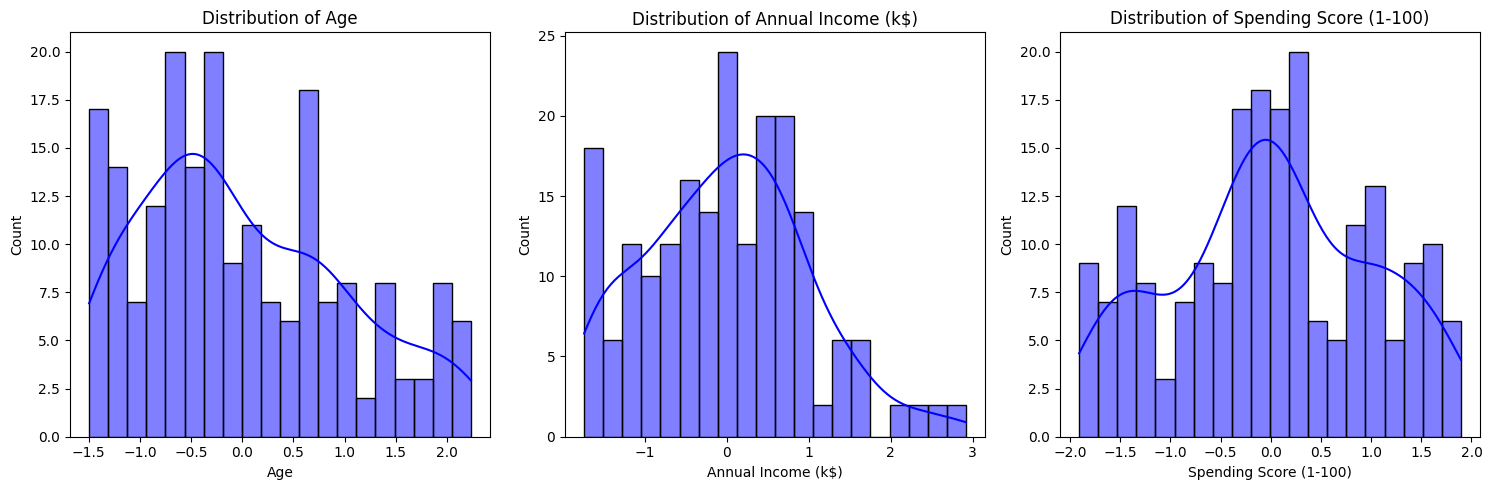

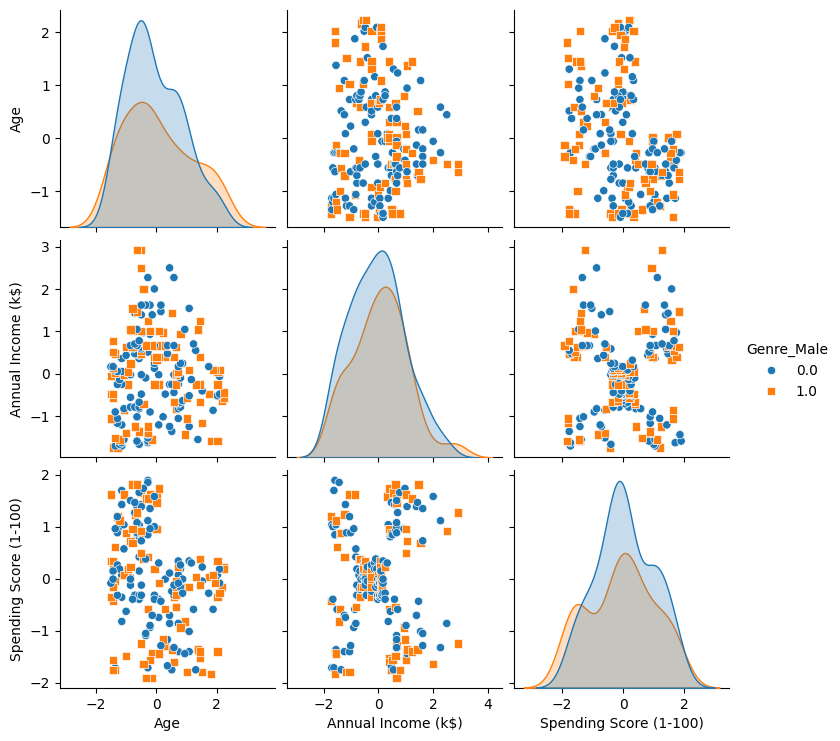

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualizing distributions of numerical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_processed[col], kde=True, bins=20, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Scattering plot for pairwise relationships
sns.pairplot(pd.DataFrame(df_processed, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Genre_Male']),
             hue='Genre_Male', diag_kind='kde', markers=["o", "s"])
plt.show()

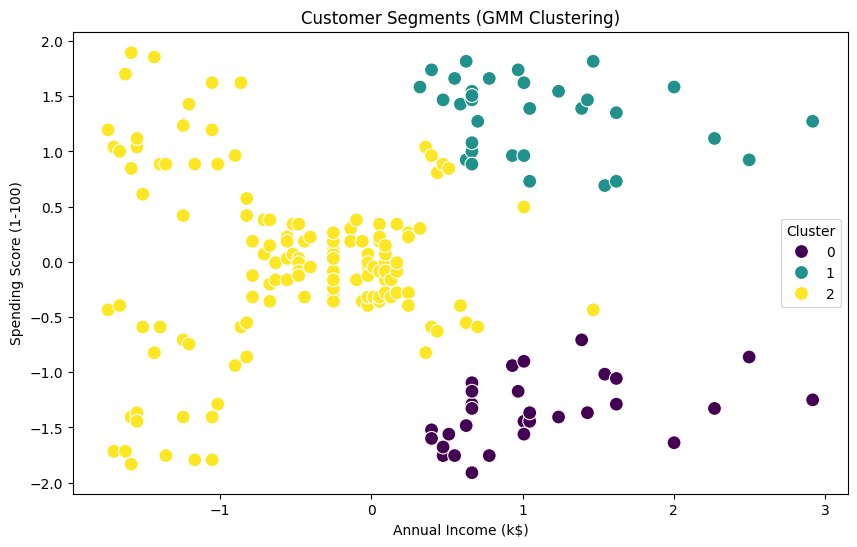

In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Selecting features for clustering
features = df_processed[['Annual Income (k$)', 'Spending Score (1-100)']]

# Applying Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  # Choosing 3 clusters for now
gmm.fit(features)

# Adding cluster labels to the dataset
df_processed['Cluster'] = gmm.predict(features)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments (GMM Clustering)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()


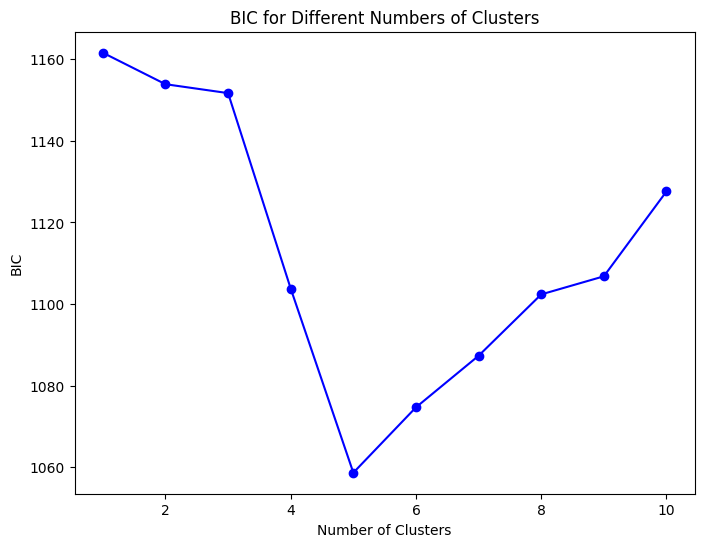

In [5]:
# Fitting the GMM model with different numbers of clusters and calculate BIC
n_clusters_range = range(1, 11)  
bic_scores = []

for n in n_clusters_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(features)  # Fit the GMM to the features
    bic_scores.append(gmm.bic(features))  # Append the BIC score for the current number of clusters

# Plotting BIC to visualize the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, bic_scores, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Different Numbers of Clusters')
plt.show()


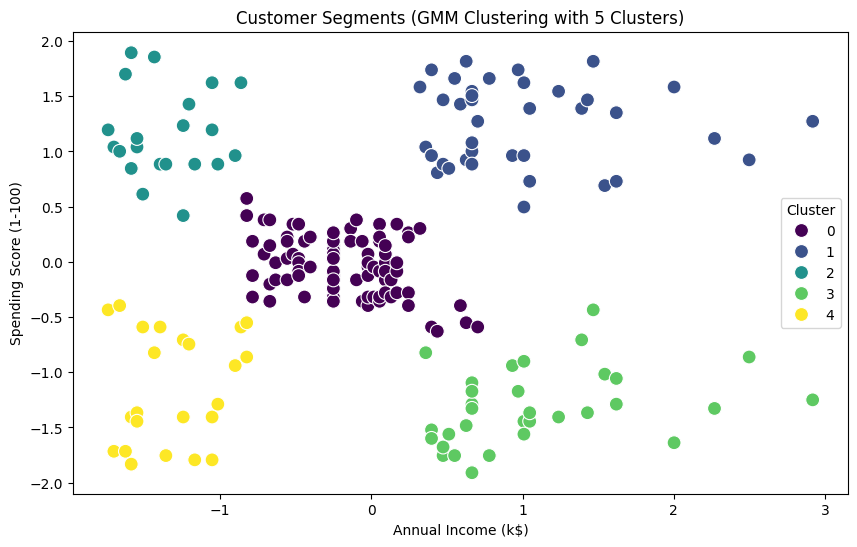

In [6]:
# Training GMM with 5 clusters
gmm_optimal = GaussianMixture(n_components=5, random_state=42)
gmm_optimal.fit(features)

# Adding cluster labels to the dataset
df_processed['Cluster'] = gmm_optimal.predict(features)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments (GMM Clustering with 5 Clusters)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()


In [7]:
# Clustering profilling

# Calculating the mean for each cluster
cluster_summary = df_processed.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_summary)

         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 -0.187685               -0.032259
1                  0.991583                1.239503
2                 -1.353670                1.158731
3                  1.078599               -1.327697
4                 -1.307519               -1.136965


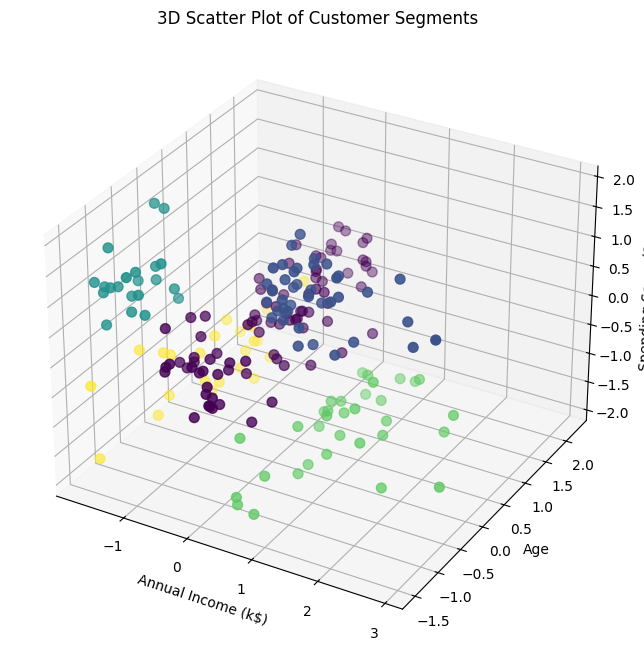

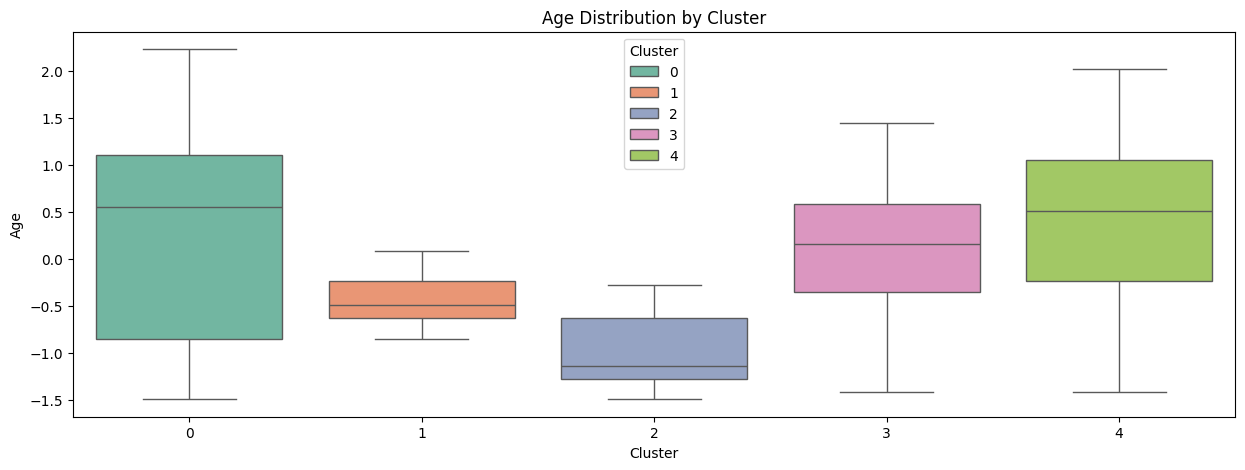

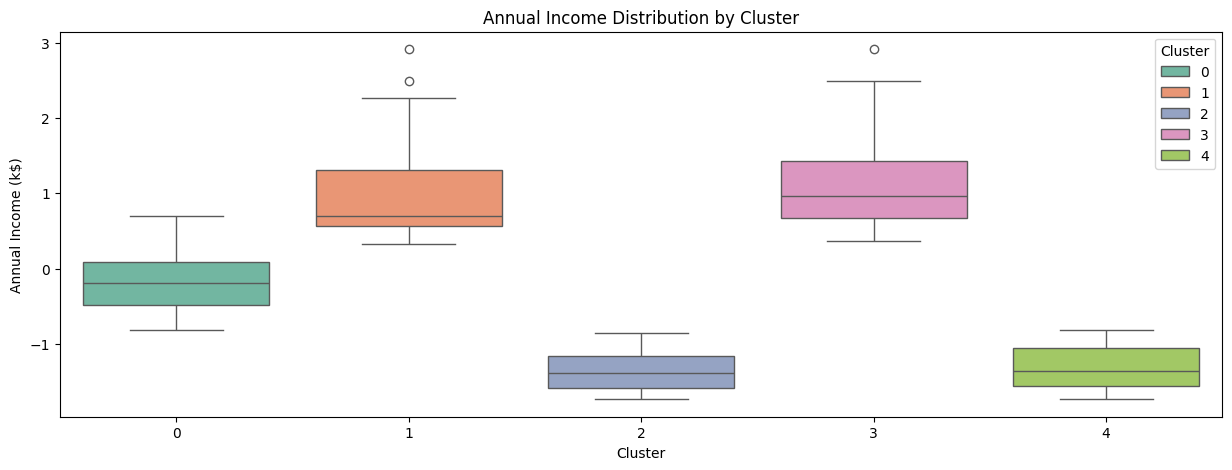

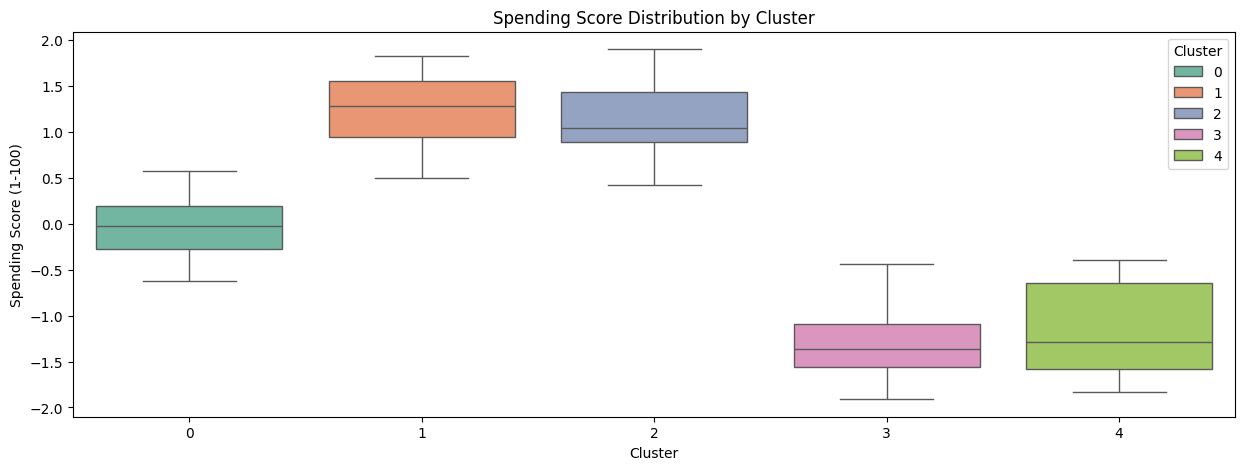

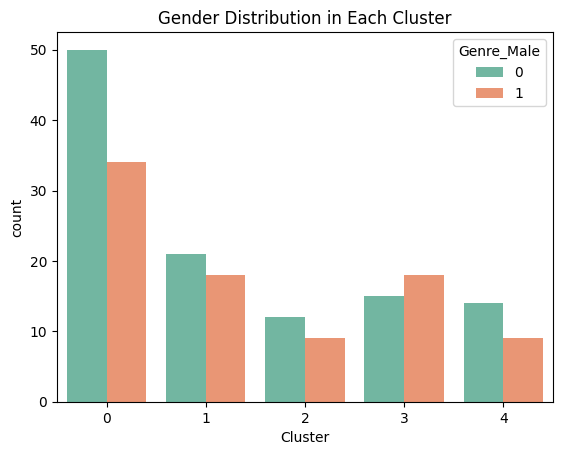

In [8]:
# Insight gathering

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Adding Genre (Male/Female) as a numeric column (for better visualization)
df_processed['Genre_Male'] = df['Genre'].apply(lambda x: 1 if x == 'Male' else 0)

# 1. 3D Scatter Plot for Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D scatter plot
ax.scatter(df_processed['Annual Income (k$)'], df_processed['Age'], df_processed['Spending Score (1-100)'], 
           c=df_processed['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Age')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D Scatter Plot of Customer Segments')

plt.show()

# 2. Boxplots for Feature Distributions by Cluster
plt.figure(figsize=(15, 5))
sns.boxplot(x='Cluster', y='Age', data=df_processed, hue='Cluster', palette='Set2')
plt.title('Age Distribution by Cluster')
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x='Cluster', y='Annual Income (k$)', data=df_processed, hue='Cluster', palette='Set2')
plt.title('Annual Income Distribution by Cluster')
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=df_processed, hue='Cluster', palette='Set2')
plt.title('Spending Score Distribution by Cluster')
plt.show()

# 3. Gender Distribution by Cluster
sns.countplot(x='Cluster', hue='Genre_Male', data=df_processed, palette='Set2')
plt.title('Gender Distribution in Each Cluster')
plt.show()

In [9]:
from sklearn.metrics import silhouette_score

# Calculates the silhouette score for the clustering
score = silhouette_score(df_processed[['Annual Income (k$)', 'Spending Score (1-100)']], df_processed['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.5536892843811245


In [10]:
from sklearn.metrics import calinski_harabasz_score

# Calculates the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(df_processed[['Annual Income (k$)', 'Spending Score (1-100)']], df_processed['Cluster'])
print(f'Calinski-Harabasz Index: {ch_score}')


Calinski-Harabasz Index: 244.9401969858632


In [11]:
from sklearn.metrics import davies_bouldin_score

# Calculates the Davies-Bouldin Index
db_score = davies_bouldin_score(df_processed[['Annual Income (k$)', 'Spending Score (1-100)']], df_processed['Cluster'])
print(f'Davies-Bouldin Index: {db_score}')


Davies-Bouldin Index: 0.5760100302410824


In [12]:
cluster_counts = df_processed['Cluster'].value_counts()
print(cluster_counts)


Cluster
0    84
1    39
3    33
4    23
2    21
Name: count, dtype: int64
